In [6]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import tqdm
import scipy
from skimage.segmentation import find_boundaries, flood, expand_labels
import skimage.measure as measure
import skimage.morphology as morphology
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def get_intake_cat():

    '''
    Return the intake catalog for barra
    '''

    #See here: https://opus.nci.org.au/pages/viewpage.action?pageId=264241965
    data_catalog = intake.open_esm_datastore("/g/data/ob53/catalog/v2/esm/catalog.json")

    return data_catalog

def load_barra_static(domain_id,lon_slice,lat_slice):

    '''
    For a barra domain, load static variables
    domain_id: for barra, either AUS-04 or AUST-11
    lat_slice: a slice to restrict lat domain
    lon_slice: a slice to restrict lon domain
    '''

    data_catalog = get_intake_cat()
    orog = data_catalog.search(variable_id="orog",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)
    lsm = data_catalog.search(variable_id="sftlf",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)

    return orog.orog, (lsm.sftlf >= 0.5) * 1

def label_and_find_coast(lsm,erosion_footprint=morphology.disk(2),size_thresh=10):

    '''
    Given a binary land-sea mask Dataarray, label the array and find boundaries (coastline)
    using skimage

    Inputs:
    erosion_footprint: A disk used to smooth/erode the binary lsm, see:
    https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html#erosion
    size_thresh: A threshold on the number of pixels for a land mass to be considered as a coastline.
    note this is applied AFTER the erosion 

    Output:
    coastline_masks: A dictionary with keys as label numbers from 0 to N, and items as a coastline mask
    label_masks: A dictionary with keys as label numbers from 0 to N, and items as a label mask
    '''

    #Label the binary land sea mask, while applying an erosion method to remove
    #parts of the coast connected by skinny land bridges (the algorithm for ordering 
    #the coastline points has trouble with that)
    if erosion_footprint is not None:
        labelled_lsm = measure.label(morphology.binary_opening(lsm,footprint=erosion_footprint),connectivity=1)
    else:
        labelled_lsm = measure.label(lsm,connectivity=1)

    #Remove labelled land masses smaller than some size threshold
    unique_labels = np.unique(labelled_lsm)
    for l in unique_labels:
        if l>0:
            if (labelled_lsm==l).sum() <= size_thresh:
                labelled_lsm[labelled_lsm==l] = 0
    unique_labels = np.unique(labelled_lsm)                

    #Get boundaries (coastlines)
    coastline_masks = []
    label_masks = []
    for l in unique_labels:
        if l>0:
            coastline_masks.append(find_boundaries(labelled_lsm==l, connectivity=1, mode="inner"))
            label_masks.append(labelled_lsm==l)

    coastline_masks = dict(zip(np.arange(len(unique_labels)),coastline_masks))
    label_masks = dict(zip(np.arange(len(unique_labels)),label_masks))
    return coastline_masks, label_masks

In [2]:
lat_slice = slice(-45,-5)
lon_slice = slice(110,155)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
coastline_labels, label_masks = label_and_find_coast(lsm,erosion_footprint=None,size_thresh=10)

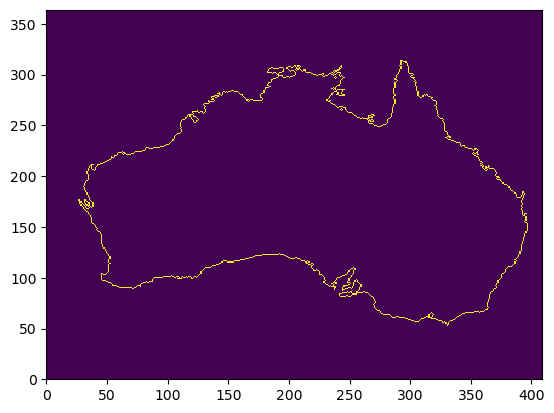

In [3]:
plt.pcolormesh(coastline_labels[2])

In [4]:
def get_coastline_angle_circle(label, lsm):

    '''
    Ewan's method. Construct a "kernel" for each coastline point to all other points, then average. Done separately for each landmass

    Input
    label: a labelled coastline array
    lsm: xarray dataarray with a binary lsm, and lat lon info

    Output
    an array of coastline angles (0-360 degrees from N) for the labelled coastline array
    '''

    lon = lsm.lon.values
    lat = lsm.lat.values
    xx,yy = np.meshgrid(lon,lat)

    #Define coastline x,y indices from the coastline mask
    xl, yl = np.where(label)

    angle_ls = []
    #Loop over coastline points
    for t in tqdm.tqdm(np.arange(len(xl))):
        angles = np.zeros(label.shape) * np.nan
        #For each coastline point, calculate the angle between it and all other points in the domain
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                angles[i,j] = np.arctan2(
                    xx[i,j] - xx[xl[t],yl[t]],
                    yy[i,j] - yy[xl[t],yl[t]])

        #Convert to degrees from N ranging from 0-360
        angles = np.rad2deg(angles)
        angles = (angles-90) % 360

        #Keep track of the kernel for later averaging
        angle_ls.append(angles)

    #Return an average over all kernels
    return scipy.stats.circmean(np.stack(angle_ls), axis=0, high=360, low=0)

l = 2
kernel_angles = get_coastline_angle_circle(coastline_labels[l], lsm)

100%|██████████| 1580/1580 [08:37<00:00,  3.05it/s]


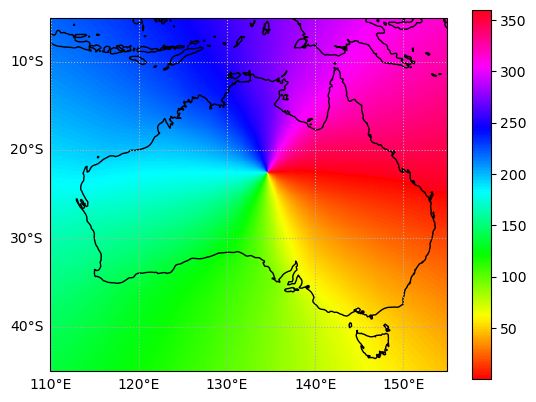

In [7]:
plt.figure()
lon = lsm.lon
lat = lsm.lat
xx,yy = np.meshgrid(lon,lat)
ax=plt.axes(projection=ccrs.PlateCarree())
c=ax.pcolormesh(xx,yy,kernel_angles,cmap="hsv")
plt.colorbar(c)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")

